In [192]:
import os
import glob
import nibabel as nib
import numpy as np
import torchvision.transforms as transforms
import torch
from torch.utils import data
from sklearn.model_selection import train_test_split


def get_slice_id(file_name):
    return int(os.path.basename(file_name).replace('.nii.gz', '').split('_')[-1])


class Hecktor22(data.Dataset):
    def __init__(self, args, augs=None):
        super(Hecktor22, self).__init__()
        self.root = args.dataroot
        self.scale_size = (args.img_width, args.img_height)
        self.augs = augs

        random_seed = args.random_seed
        patient_ids = os.listdir(self.root)
        patients_train, patients_test = train_test_split(patient_ids, test_size=0.22, random_state=random_seed)
        
        if args.phase == 'train':
            patients = patients_train
        elif args.phase == 'test':
            patients = patients_test

        gt_masks = []
        imgs = []
        for id in patients:
            imgs_patient = glob.glob(f'{self.root}/{id}/images/*')
            imgs_patient.sort(key = lambda x: get_slice_id(x))

            gt_folders = glob.glob(f'{self.root}/{id}/labels/*')
            gt_patient = []
            for img in imgs_patient:
                slice_name = os.path.basename(img)
                gt_slice = []
                for gt_dir in gt_folders:
                    gt_path = f'{gt_dir}/{slice_name}'
                    gt_slice.append(gt_path)
                gt_patient.append(gt_slice)
            
            imgs.extend(imgs_patient)
            gt_masks.extend(gt_patient)
        
        self.imgs = imgs
        self.labels = gt_masks            

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = nib.load(self.imgs[index]).get_fdata()
        gt = []
        for gt_path in self.labels[index]:
            gt.append(nib.load(gt_path).get_fdata())
        
        masks = list()
        for mask in gt:
            mask = mask[:, :, 0]
            
            gtvp = mask.copy()
            gtvp[gtvp != 1] = 0

            gtvn = mask.copy()
            gtvn[gtvn != 2] = 0
            gtvn[gtvn == 2] = 1

            mask_ = np.stack((gtvp, gtvn))
            masks.append(mask_)
        
        n_valid_masks = len(masks)
        while len(masks) < 4:
            masks.append(mask_)

        return {'image': torch.tensor(img, dtype=torch.float32), 
                'mask': masks,
                'name': self.imgs[index],
                'n_valid_masks': n_valid_masks}


In [25]:
import os
import glob
from sklearn.model_selection import train_test_split

In [23]:
random_seed = 27
path = '/home/kudaibergen/projects/sa/data/hecktor22_test_2d'
patient_ids = os.listdir(path)
patients_train, patients_test = train_test_split(patient_ids, test_size=0.22, random_state=random_seed)

In [114]:
len(patients_train), len(patients_test)

(34, 10)

In [116]:
patients_train

['CHB-028',
 'MDA-328',
 'CHB-047',
 'USZ-001',
 'MDA-398',
 'MDA-342',
 'USZ-015',
 'MDA-371',
 'MDA-216',
 'CHB-005',
 'USZ-078',
 'USZ-043',
 'MDA-244',
 'USZ-029',
 'USZ-008',
 'USZ-050',
 'CHB-051',
 'USZ-099',
 'USZ-022',
 'CHB-043',
 'MDA-230',
 'USZ-085',
 'MDA-272',
 'USZ-071',
 'CHB-056',
 'MDA-286',
 'MDA-314',
 'CHB-031',
 'USZ-064',
 'CHB-039',
 'CHB-023',
 'CHB-060',
 'MDA-258',
 'USZ-092']

In [115]:
patients_test

['USZ-057',
 'CHB-009',
 'CHB-014',
 'MDA-384',
 'MDA-202',
 'CHB-001',
 'CHB-035',
 'USZ-036',
 'CHB-019',
 'MDA-356']

In [45]:
def get_slice_id(file_name):
    return int(os.path.basename(file_name).replace('.nii.gz', '').split('_')[-1])

gt_masks = []
imgs = []
for id in patients_train:
    imgs_patient = glob.glob(f'{path}/{id}/images/*')
    imgs_patient.sort(key = lambda x: get_slice_id(x))

    gt_folders = glob.glob(f'{path}/{id}/labels/*')
    gt_patient = []
    for img in imgs_patient:
        slice_name = os.path.basename(img)
        gt_slice = []
        for gt_dir in gt_folders:
            gt_path = f'{gt_dir}/{slice_name}'
            gt_slice.append(gt_path)
        gt_patient.append(gt_slice)
    
    imgs.extend(imgs_patient)
    gt_masks.extend(gt_patient)
    

In [46]:
len(imgs), \
len(gt_masks)

(10540, 10540)

In [174]:
mask[:, :, 0].shape

(200, 200)

In [48]:
imgs[0]

'/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/images/0_0.nii.gz'

In [49]:
gt_masks[0]

['/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/panagiotis/0_0.nii.gz',
 '/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/mario/0_0.nii.gz',
 '/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/labelsTs/0_0.nii.gz']

In [180]:
type(img.get_fdata().dtype)

numpy.dtype[float64]

In [50]:
import nibabel as nib

In [198]:
index = 13*310 + 100
img = nib.load(imgs[index])
gt = []
for gt_path in gt_masks[index]:
    gt.append(nib.load(gt_path))

In [199]:
img.get_fdata().shape

(2, 200, 200)

In [61]:
import matplotlib.pyplot as plt

In [83]:
gt[2].get_fdata().shape

(200, 200, 1)

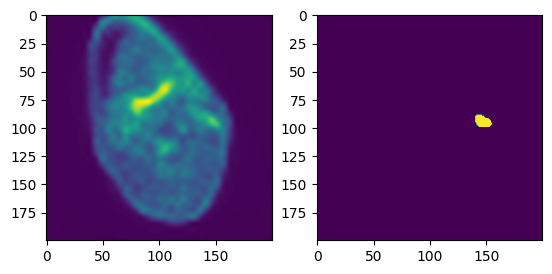

In [164]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(np.transpose(img.get_fdata()[1]))
axes[1].imshow(np.transpose(gt[0].get_fdata())[0])

In [162]:
mask = gt[0].get_fdata()

In [163]:
np.unique(mask)

array([0., 2.])

In [167]:
type(mask)

numpy.ndarray

In [120]:
mask.shape

(200, 200, 1)

In [123]:
mask.min()

0.0

In [124]:
gt_masks[160]

['/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/panagiotis/0_160.nii.gz',
 '/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/mario/0_160.nii.gz',
 '/home/kudaibergen/projects/sa/data/hecktor22_test_2d/CHB-028/labels/labelsTs/0_160.nii.gz']

In [125]:
np.unique(mask)

array([0.])

In [188]:
from torch.utils.data import DataLoader

In [184]:
random_seed = 27
path = '/home/kudaibergen/projects/sa/data/hecktor22_test_2d'

class args_struct:
    def __init__(self):
        self.dataroot = '/home/kudaibergen/projects/sa/data/hecktor22_test_2d'
        self.img_width = 200
        self.img_height = 200
        self.random_seed = 27
        self.phase = 'train'
args = args_struct()

In [193]:
train_dataset = Hecktor22(args)

In [260]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [204]:
mask.shape

torch.Size([4, 2, 200, 200])

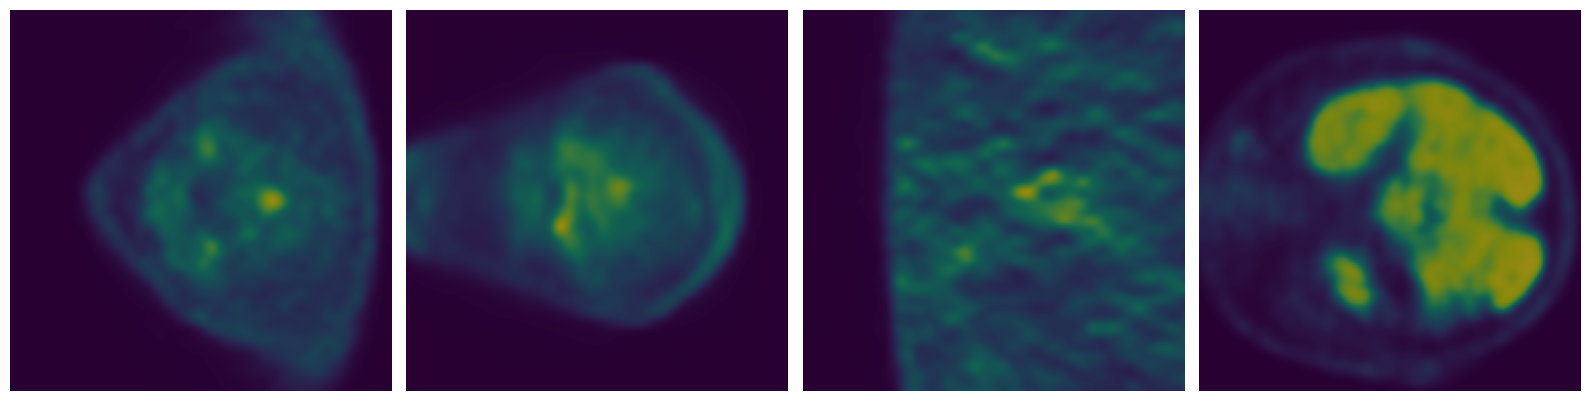

In [236]:
batch_data = next(iter(train_loader))

plt.figure(figsize=(16, 16))
for i,(img,mask) in enumerate(zip(batch_data['image'], batch_data['mask'])):
    # img = ((img.permute(1,2,0))*255.0).numpy().astype(np.uint8)
    plt.subplot(2, 4, i+1)
    plt.imshow(img[1])
    plt.imshow(mask[0][0].numpy(), alpha=0.4, cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=0.1)

plt.tight_layout()

In [215]:
img.shape

torch.Size([2, 200, 200])

In [217]:
batch_data['image'].shape

torch.Size([4, 2, 200, 200])

In [237]:
mask[0][0].sum()

tensor(0., dtype=torch.float64)

In [238]:
mask[0][1].sum()

tensor(0., dtype=torch.float64)

In [241]:
from tqdm import tqdm

In [270]:
count_empty = 0
for batch in tqdm(train_loader, total=len(train_loader)):
    mask = batch['mask'][0]
    for m in mask:
        if m[0].sum() == 0 and m[1].sum() == 0:
            count_empty += 1

100%|██████████| 659/659 [02:44<00:00,  4.01it/s]


In [257]:
batch['mask'][0].shape

torch.Size([4, 2, 200, 200])

In [266]:
len(batch['mask'][0])

12

In [269]:
batch['mask'][0].shape

torch.Size([12, 2, 200, 200])

In [271]:
count_empty

8481

In [247]:
mask.shape

AttributeError: 'list' object has no attribute 'shape'

In [246]:
mask[0][0].shape

torch.Size([2, 200, 200])

In [ ]:
for b